## Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

In [2]:
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2"))

In [3]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 16,        # global base font
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})
mpl.rcParams["grid.linestyle"] = "--"   # dashed
mpl.rcParams["grid.linewidth"] = 0.8    # optional

## Overview barplot

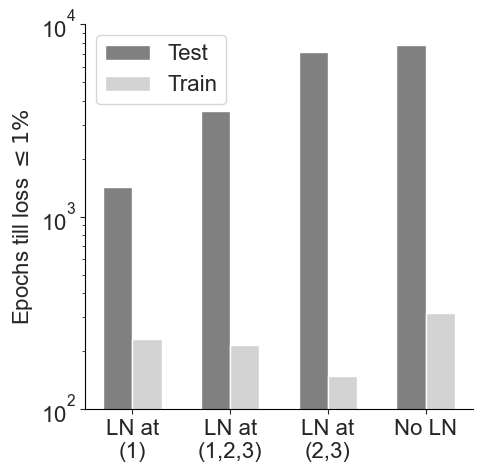

In [6]:

types = ["none", "attn-pre", "pre", "mlp-pre"]
df = pd.read_csv("./data/trf-1l_lecun_test_loss.csv")
maxit = lambda x: f"model.ln_type: {x} - test/loss__MAX"
minit =  lambda x: f"model.ln_type: {x} - test/loss__MIN"
meanit =  lambda x: f"model.ln_type: {x} - test/loss"
position_map = {"off": "No LN", "pre": "Pre-LN", "attn-pre": "Attn Pre-LN", "mlp-pre": "MLP Pre-LN"}
steps = df["Step"]
data = {}

train_data = {}
t2 = types
t2[0] = "off"


tdf = pd.read_csv("./data/ln_train_loss.csv")
t_meanit =  lambda x: f"model.ln_type: {x} - train/loss"

for t in t2:
    test_mask = (df[meanit(t)] <= 0.01).tolist()
    test_point = df["Step"][test_mask.index(True)]
    data[t] = test_point
    
    train_mask = (tdf[t_meanit(t)] <= 0.01).tolist()
    train_point = df["Step"][train_mask.index(True)]
    train_data[t] = train_point

labels = list(data.keys())
labels.reverse()

tests = list(data.values())
tests.reverse()

trains = list(train_data.values())
trains.reverse()
x = np.arange(len(labels))


final_labels = ["LN at\n(1)", "LN at\n(1,2,3)", "LN at\n(2,3)", r"No LN"]

plt.figure(figsize=(5,5))

w = 0.3
plt.bar(x - w/2, tests, width=w, color="gray", label="Test")
plt.bar(x+ w/2, trains, width=w, color="lightgray", label="Train")
plt.yscale("log")
plt.xticks(x, final_labels, fontsize=16)
plt.yticks([100, 1000, 10000], fontsize=16)
plt.ylabel(r"Epochs till loss $\leq 1\%$", fontsize=16)

plt.grid(False)
plt.legend(fontsize=16)

ax = plt.gca()

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# ax_left = ax.twinx()
# ax_left.bar(x+ w/2, trains, width=w, label="train", color="C1")
# ax_left.set_ylim([100, 10000])
# ax_left.set_yticks([100, 1000, 10000], [r"$10^2$", r"$10^3$", r"$10^4$"], fontsize=16)
# ax_left.set_ylabel("Epochs till perfect train fit", fontsize=16)
# ax_left.set_yscale("log")
# ax_left.grid(False)

# ax_left.spines["right"].set_visible(True)
# ax_left.spines["bottom"].set_visible(True)
# ax_left.spines["top"].set_visible(False)
# ax_left.spines["left"].set_visible(False)

# ax_left.spines["right"].set_color("black")
# ax_left.spines["bottom"].set_color("black")

# ax_left.yaxis.set_ticks_position("right")
# ax_left.xaxis.set_ticks_position("bottom")

plt.savefig("./new_figs/overv_barplot.png", dpi=300, bbox_inches="tight")
plt.show()
    

## MLP memorization

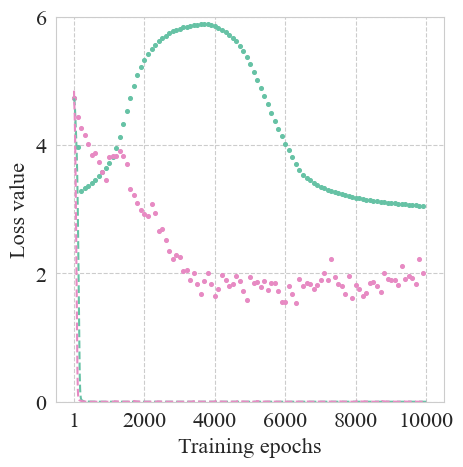

In [59]:
df_none = pd.read_csv("check_data/none_mem_train_loss.csv")
df_mlppre = pd.read_csv("check_data/ln_mem_train_loss.csv")

def get(item, mode):
    db = None
    if mode == "none":
        pref = "Grouped runs"
        db = df_none
    elif mode == "mlp-pre":
        pref = "model.ln_type: mlp-pre"
        db = df_mlppre
        
    key = ""
    if item == "max":
        key = pref+" - train/loss__MAX"
    if item == "min":
        key = pref+" - train/loss__MIN"
    if item == "mean":
        key = pref+" - train/loss"
    return db[key]
    
def get_spec(item, mode):
    db = None
    if mode == "none":
        pref = "Grouped runs"
        db = df_none 
    elif mode == "mlp-pre":
        pref = "model.ln_type: mlp-pre"
        db = df_mlppre
    
    key = "" 
    if item == "max":
        key = pref+" - train/spec_loss__MAX"
    if item == "min":
        key = pref+" - train/spec_loss__MIN"
    if item == "mean":
        key = pref+" - train/spec_loss"
    return db[key]

def diff(x, y, mode, clean=False):
    if clean:
        return np.minimum.accumulate(get_spec(x, mode)) - np.minimum.accumulate(get(y, mode))
    return get_spec(x, mode) - get(y, mode)

steps = df_none["Step"]
plt.figure(figsize=(5,5))
plt.plot(steps, get("min", "none"), linestyle="--", c="C0")
plt.scatter(steps[::100], get_spec("min", "none")[::100], c="C0", s=7)

plt.plot(steps, get("min", "mlp-pre"), linestyle="--", c="C3")
plt.scatter(steps[::100], get_spec("min", "mlp-pre")[::100], c="C3", s=7)

plt.plot([], [], c="gray", linestyle="--", label="Train")
plt.scatter([], [], c="gray", marker="o", label="SR-train")
plt.plot([], [], c="C0", linestyle="-", label="No LN")
plt.plot([], [], c="C3", linestyle="-", label="M")

plt.xticks([1]+[u*1000 for u in [2,4,6,8,10]])
plt.xlabel("Training epochs")
plt.ylim([0,6])
plt.yticks([0, 2, 4, 6])
plt.ylabel("Loss value")
# plt.legend(ncol=2, loc="upper center", framealpha=1,)
plt.savefig("new_figs/noln_v_m_memo.png", dpi=300, bbox_inches="tight")
plt.show()

## Attention QKV

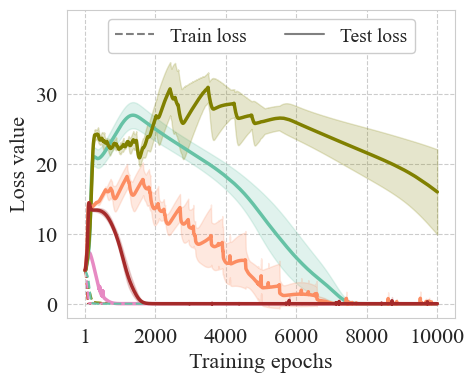

In [25]:
import warnings
warnings.simplefilter("ignore")

df = pd.read_csv("check_data/attn_types.csv")
meanit = lambda x: f"model.ln_type: {x} - test/loss"
maxit = lambda x: f"model.ln_type: {x} - test/loss__MAX"
minit = lambda x: f"model.ln_type: {x} - test/loss__MIN"

tdf = pd.read_csv("check_data/attn_types_train_loss.csv")
t_meanit =lambda x: f"model.ln_type: {x} - train/loss" 

no_ln_df = pd.read_csv("./data/trf-1l_lecun_test_loss.csv")
no_ln_tdf = pd.read_csv("./data/ln_train_loss.csv")

pos_map = {
    "off": "No LN",
    "attn-pre-qk": r"A$^{qk}$", 
    "attn-pre": "A*", 
    "attn-pre-v": r"A$^{v}$", 
    # "pre-v": r"M+$\text{A}^{v}$",
    "mlp-pre": "M"
}
c_map = {
    "off": "C0",
    "attn-pre-qk": "olive", 
    "attn-pre": "C1", 
    "attn-pre-v": "brown",
    "mlp-pre": "C3" 
}
steps = df["Step"]
plt.figure(figsize=(5,4))
for k, v in pos_map.items():
    if k != "off":
        if k == "mlp-pre":
            tr = tdf[t_meanit(k)]
            tr[100:] = np.minimum.accumulate(tr[100:])
        else:
            tr = tdf[t_meanit(k)]
            tr[500:] = np.minimum.accumulate(tr[500:])
        plt.plot(steps, tr, linestyle="--", c=c_map[k], zorder=0)
        
        if k != "mlp-pre":
            y = df[meanit(k)]
            std = (df[maxit(k)] - df[minit(k)]) / 4
            plt.plot(steps, y, c=c_map[k], linewidth=2.5, zorder=2) # label=v
            plt.fill_between(steps, y-std, y+std, alpha=0.2, color=c_map[k])
        else:
            y = df[meanit(k)]
            y[800:] = np.minimum.accumulate(y[800:])
            # std = (df[maxit(k)] - df[minit(k)]) / 4
            plt.plot(steps, y, c=c_map[k], linewidth=2.5, zorder=1) # label=v
            # plt.fill_between(steps, y-std, y+std, alpha=0.2, color=c_map[k])
    else:
        mean_test = no_ln_df["model.ln_type: off - test/loss"]
        max_test = no_ln_df["model.ln_type: off - test/loss__MAX"]
        min_test = no_ln_df["model.ln_type: off - test/loss__MIN"]
        mean_train = no_ln_tdf["model.ln_type: off - train/loss"]
        
        plt.plot(steps, mean_train, linestyle="--", c=c_map[k])
        plt.plot(steps, mean_test, c=c_map[k], linewidth=2.5) # label=v
        std = (max_test - min_test)/4
        plt.fill_between(steps, mean_test-std, mean_test+std, alpha=0.2, color=c_map[k])

plt.plot([], [], linestyle="--", label="Train loss", c="gray")
plt.plot([], [], label="Test loss", c="gray")

plt.legend(loc="upper center", fontsize=14, framealpha=1, ncol=2)

plt.xlabel("Training epochs")
plt.xticks([1]+[i*1000 for i in [2,4,6,8,10]])
plt.ylabel("Loss value")
plt.yticks([0, 10, 20, 30])
plt.ylim([-2, 42])
# plt.legend(loc="upper right")
plt.savefig("new_figs/ln_ib_b.png", dpi=300, bbox_inches="tight")
plt.show()
    

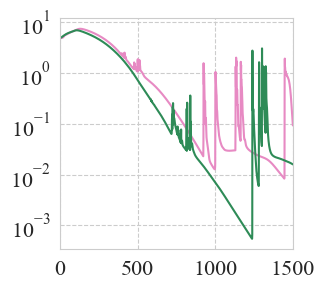

In [165]:
import warnings
warnings.simplefilter("ignore")

df = pd.read_csv("check_data/attn_types.csv")
meanit = lambda x: f"model.ln_type: {x} - test/loss"
maxit = lambda x: f"model.ln_type: {x} - test/loss__MAX"
minit = lambda x: f"model.ln_type: {x} - test/loss__MIN"

pos_map = {
    "mlp-pre": "M",
    "pre-v": r"M+$\text{A}^{v}$"
}

c_map = {"pre-v": "seagreen", "mlp-pre": "C3"}

steps = df["Step"]
plt.figure(figsize=(3,3))
for k, v in pos_map.items():
    y = df[meanit(k)]
    plt.plot(steps, y, alpha=1, c=c_map[k], label=v)
    
    y[200:] = np.minimum.accumulate(y[200:])
    # plt.plot(steps, y, label=v, c=c_map[k])
    
    # std = (df[maxit(k)] - df[minit(k)]) / 4
    # plt.fill_between(steps, abs(y-std), abs(y+std), alpha=0.2)

# plt.xlabel("Training epochs")
# plt.xticks([1]+[i*1000 for i in [2,4,6,8,10]])
plt.xlim([0, 1500])
plt.yscale("log")
# plt.ylim([-2, 37])
# plt.legend(loc="lower left")
plt.savefig("new_figs/m_vs_m+a-v_loss_zoom.png", dpi=300, bbox_inches="tight")
plt.show()

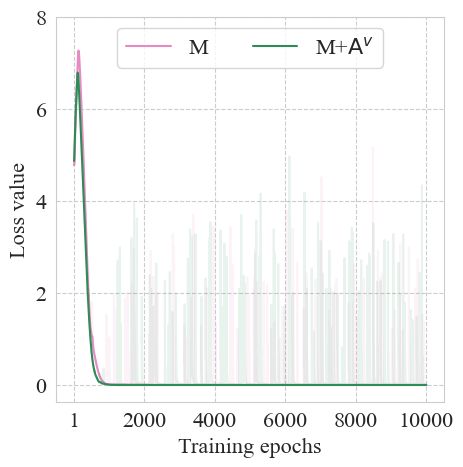

In [ ]:

import warnings
warnings.simplefilter("ignore")

df = pd.read_csv("check_data/attn_types.csv")
meanit = lambda x: f"model.ln_type: {x} - test/loss"
maxit = lambda x: f"model.ln_type: {x} - test/loss__MAX"
minit = lambda x: f"model.ln_type: {x} - test/loss__MIN"

pos_map = {
    "mlp-pre": "M",
    "pre-v": r"M+A$^{v}$"
}

c_map = {"pre-v": "seagreen", "mlp-pre": "C3"}

steps = df["Step"]
plt.figure(figsize=(5,5))
for k, v in pos_map.items():
    y = df[meanit(k)]
    plt.plot(steps, y, alpha=0.1, c=c_map[k])
    
    y[200:] = np.minimum.accumulate(y[200:])
    plt.plot(steps, y, label=v, c=c_map[k])
    
    # std = (df[maxit(k)] - df[minit(k)]) / 4
    # plt.fill_between(steps, abs(y-std), abs(y+std), alpha=0.2)

plt.xlabel("Training epochs")
plt.xticks([1]+[i*1000 for i in [2,4,6,8,10]])
# plt.xlim([0, 1500])
plt.ylabel("Loss value")
plt.yticks([0, 2, 4, 6, 8])
plt.legend(loc="upper center", ncol=2)
plt.savefig("new_figs/m_vs_m+a-v_loss.png", dpi=300, bbox_inches="tight")
plt.show()

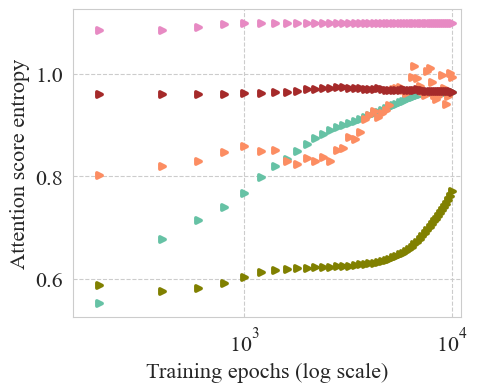

In [11]:
df = pd.read_csv("check_data/attn_ln_analysis.csv")
metrics = ["attn_out_eff_rank", "attn_score_entropy"]
pos_map = {
    "off": "No LN", 
    "attn-pre-qk": r"A$^{qk}$", 
    "attn-pre": "A*", 
    "attn-pre-v": r"A$^{v}$",
    # "pre-v": r"M+$\text{A}^{v}$",
    "mlp-pre": "M"
}
c_map = {
    "off": "C0", 
    "attn-pre-qk": "olive", 
    "attn-pre": "C1", 
    "attn-pre-v": "brown",
    "mlp-pre": "C3"
}
m = metrics[1]
plt.figure(figsize=(5,4))
for t in pos_map.keys():
    x, y = df["steps"], df[f"{t}__{m}"]
    plt.scatter(x[1:], y[1:], s=15, label=pos_map[t], marker=">", c=c_map[t], linewidth=2.5)

plt.ylabel("Attention score entropy")
plt.xlabel("Training epochs (log scale)")
plt.yticks([0.6, 0.8, 1.0])
# plt.xticks([1]+[i*1000 for i in [2,4,6,8,10]])
plt.xscale("log")
plt.xticks([1000, 10000])
plt.xlim([150,11000])
plt.savefig("new_figs/attn_qkv_entropy.png", dpi=300, bbox_inches="tight")
plt.show()

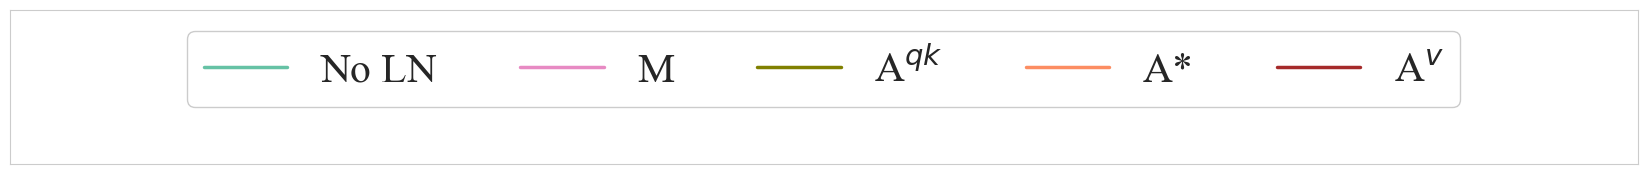

In [17]:
plt.figure(figsize=(21,2))
# plt.plot([], [], linestyle="--", c="gray", label="Train loss")
# plt.plot([], [], linewidth=2.5, c="gray", label="Test loss")
# plt.scatter([], [], c="gray", label="SR-train loss")
# plt.scatter([], [], c="gray", marker=">", label="Attention entropy")
plt.plot([], [], linewidth=2.5, c="C0", label="No LN")
plt.plot([], [], linewidth=2.5, c="C3", label="M")

pos_map = {
    "attn-pre-qk": r"A$^{qk}$", 
    "attn-pre": "A*", 
    "attn-pre-v": r"A$^{v}$",
}
c_map = {
    "attn-pre-qk": "olive", 
    "attn-pre": "C1", 
    "attn-pre-v": "brown",
}
for k, v in pos_map.items():
    plt.plot([], [], linewidth=2.5, label=v, c=c_map[k])

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.legend(ncol=9, loc="upper center", framealpha=1, fontsize=30)
plt.savefig("new_figs/ln_ib_legend.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
df_attnv = pd.read_csv("check_data/attn_v_mlp_mem_train.csv")
df_attnv.head()

,Step,model.ln_type: attn-pre-v - train/loss,model.ln_type: attn-pre-v - train/loss__MIN,model.ln_type: attn-pre-v - train/loss__MAX,model.ln_type: attn-pre-v - train/spec_loss,model.ln_type: attn-pre-v - train/spec_loss__MIN,model.ln_type: attn-pre-v - train/spec_loss__MAX
0,1,4.821039,4.805120,4.844284,4.737709,4.735433,4.739111
1,2,4.763244,4.755772,4.773927,4.734581,4.732901,4.735582
2,3,4.731512,4.725080,4.738559,4.731836,4.730473,4.732777
3,4,4.705904,4.698967,4.712913,4.729318,4.728119,4.730412
4,5,4.681998,4.674710,4.689975,4.726939,4.725807,4.728144


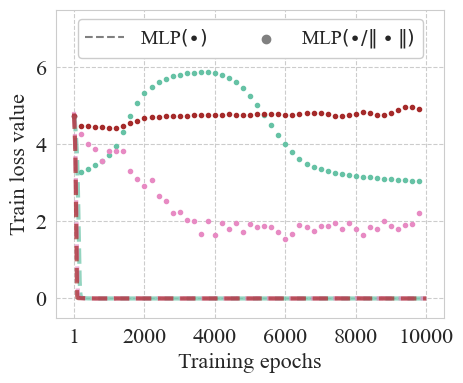

In [13]:

df_none = pd.read_csv("check_data/none_mem_train_loss.csv")
df_mlppre = pd.read_csv("check_data/ln_mem_train_loss.csv")
df_attnv = pd.read_csv("check_data/attn_v_mlp_mem_train.csv")

def get(item, mode):
    db = None
    if mode == "none":
        pref = "Grouped runs"
        db = df_none
    elif mode == "mlp-pre":
        pref = "model.ln_type: mlp-pre"
        db = df_mlppre
    elif mode == "attn-pre-v":
        pref = "model.ln_type: attn-pre-v"
        db = df_attnv
        
    key = ""
    if item == "max":
        key = pref+" - train/loss__MAX"
    if item == "min":
        key = pref+" - train/loss__MIN"
    if item == "mean":
        key = pref+" - train/loss"
    return db[key]
    
def get_spec(item, mode):
    db = None
    if mode == "none":
        pref = "Grouped runs"
        db = df_none 
    elif mode == "mlp-pre":
        pref = "model.ln_type: mlp-pre"
        db = df_mlppre
    elif mode == "attn-pre-v":
        pref = "model.ln_type: attn-pre-v"
        db = df_attnv
    
    key = "" 
    if item == "max":
        key = pref+" - train/spec_loss__MAX"
    if item == "min":
        key = pref+" - train/spec_loss__MIN"
    if item == "mean":
        key = pref+" - train/spec_loss"
    return db[key]

def diff(x, y, mode, clean=False):
    if clean:
        return np.minimum.accumulate(get_spec(x, mode)) - np.minimum.accumulate(get(y, mode))
    return get_spec(x, mode) - get(y, mode)

steps = df_none["Step"]
plt.figure(figsize=(5,4))
plt.plot(steps, get("min", "none"), linestyle="--", linewidth=3, c="C0", alpha=0.7)
plt.scatter(steps[::200], get_spec("min", "none")[::200], c="C0", s=9)

plt.plot(steps, get("min", "mlp-pre"), linestyle="--", linewidth=3, c="C3", alpha=0.7)
plt.scatter(steps[::200], get_spec("min", "mlp-pre")[::200], c="C3", s=9)

plt.plot(steps, get("min", "attn-pre-v"), linestyle="--", linewidth=3, c="brown", alpha=0.7)
plt.scatter(steps[::200], get_spec("min", "attn-pre-v")[::200], c="brown", s=9)

plt.plot([], [], c="gray", linestyle="--", label=r"MLP$(\bullet)$")
plt.scatter([], [], c="gray", marker="o", label=r"MLP$(\bullet / \|\bullet\|)$")
# plt.plot([], [], c="C0", linestyle="-", label="No LN")
# plt.plot([], [], c="C3", linestyle="-", label="M")

plt.legend(loc="upper center", framealpha=1, ncol=2, fontsize=14)
plt.xticks([1]+[u*1000 for u in [2,4,6,8,10]])
plt.xlabel("Training epochs")
# plt.yscale("log")
plt.ylim([-0.5, 7.5])
plt.yticks([0, 2, 4, 6])
plt.ylabel("Train loss value")
# plt.title(r"Train loss sensitivity to MLP input scale")#: MLP$(\bullet)$ vs MLP$(\bullet / \|\bullet\|)$")
# plt.legend(ncol=2, loc="upper center", framealpha=1,)
plt.savefig("new_figs/ln_ib_1.png", dpi=300, bbox_inches="tight")
plt.show()

## D=3, W=64

In [28]:
def smooth(x, window=5, mode="reflect"):
    """
    x: 1D array-like time series
    window: smoothing window size (odd recommended)
    mode: padding mode passed to np.pad (e.g. 'reflect', 'edge', 'constant')
    """
    x = np.asarray(x)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window == 1:
        return x.copy()

    pad = window // 2
    x_pad = np.pad(x, pad_width=pad, mode=mode)
    kernel = np.ones(window) / window
    y = np.convolve(x_pad, kernel, mode="valid")
    return y

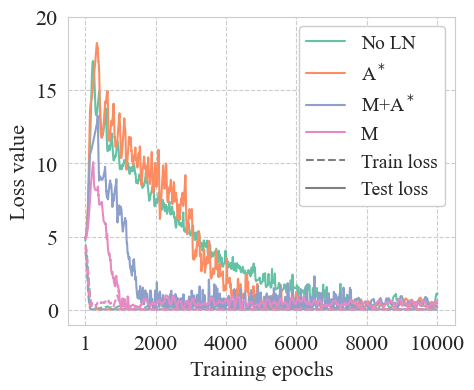

In [89]:
df = pd.read_csv("data/d3_w64_test_loss.csv")
tdf = pd.read_csv("data/d3_w64_train_loss.csv")

t2 = ["off", "attn-pre", "pre", "mlp-pre"]
meanit = lambda x, d: f"model.ln_type: {x} - {d}/loss"
maxit = lambda x, d: f"model.ln_type: {x} - {d}/loss__MAX"
minit = lambda x, d: f"model.ln_type: {x} - {d}/loss__MIN"

name_map = {
    "off": "No LN",
    "attn-pre": r"A$^*$",
    "pre": r"M+A$^*$",
    "mlp-pre": r"M"
}

steps = df["Step"]
plt.figure(figsize=(5,4))
for i, t in enumerate(t2):
    y = df[meanit(t, "test")]
    idx = (y <= 0.05).tolist().index(True)
    y[idx:] = smooth(y[idx:], 111) #np.minimum.accumulate(y[idx:])
    plt.plot(steps, smooth(y, 17), label=name_map[t], c=f"C{i}")
    
    tr = tdf[meanit(t, "train")]
    tridx = (tr <= 0.05).tolist().index(True)
    tr[tridx:] = tr[tridx]
    # tr[tridx:] = smooth(tr[tridx:], 111) #np.minimum.accumulate(y[idx:])
    # tr = np.minimum.accumulate(tr)
    plt.plot(steps, smooth(tr, 111), linestyle="--", c=f"C{i}")

plt.plot([], [], c="gray", label="Train loss", linestyle="--")
plt.plot([], [], c="gray", label="Test loss")

plt.legend(fontsize=14, framealpha=1, loc="upper right")
plt.xticks([1, 2000, 4000, 6000, 8000, 10000])
plt.xlabel("Training epochs")
plt.yticks([0, 5, 10, 15, 20])
plt.ylim([-1, 20])
plt.ylabel("Loss value")
plt.savefig("new_figs/d3_w64_loss.png", dpi=300, bbox_inches="tight")
plt.show()

## RMSNorm

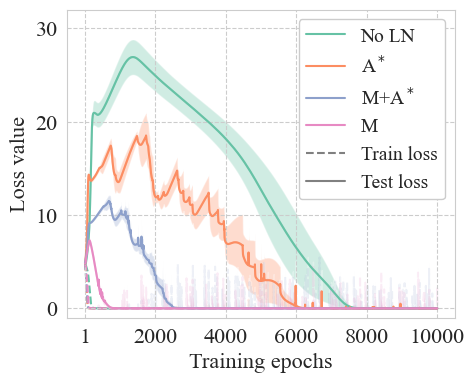

In [88]:

df = pd.read_csv("data/rmsnorm_loss.csv")
t2 = ["off", "attn-pre", "pre", "mlp-pre"]

meanit = lambda x, d: f"model.ln_type: {x} - {d}/loss"
maxit = lambda x, d: f"model.ln_type: {x} - {d}/loss__MAX"
minit = lambda x, d: f"model.ln_type: {x} - {d}/loss__MIN"

name_map = {
    "off": "No LN",
    "attn-pre": r"A$^*$",
    "pre": r"M+A$^*$",
    "mlp-pre": r"M"
}

steps = df["Step"]
plt.figure(figsize=(5,4))
for i, t in enumerate(t2):
    y = df[meanit(t, "test")]
    tmp = y
    
    if t == "mlp-pre":
        y[1000:] = np.minimum.accumulate(y[1000:])
    if t == "pre":
        y[1800:2000] = np.minimum.accumulate(y[1800:2000])
        y[2000:2800] = np.minimum.accumulate(y[2000:2800])
        y[2800:] = np.minimum.accumulate(y[2800:])
    
    std = (df[maxit(t, "test")] - df[minit(t, "test")]) / 4
    plt.plot(steps, y, label=name_map[t], c=f"C{i}", zorder=1)
    plt.plot(steps, tmp, c=f"C{i}", alpha=0.3, zorder=0)
    plt.fill_between(steps, (y-std).clip(0.0), y+std, alpha=0.3, zorder=0)
    
    tr = df[meanit(t, "train")]
    tmp2 = tr
    tr = np.minimum.accumulate(tr) 
    plt.plot(steps, tmp2, linestyle="--", c=f"C{i}", alpha=0.15, zorder=0)
    plt.plot(steps, tr, linestyle="--", c=f"C{i}", zorder=0)

plt.plot([], [], c="gray", label="Train loss", linestyle="--")
plt.plot([], [], c="gray", label="Test loss")

plt.legend(fontsize=14, framealpha=1, loc="upper right")
plt.xticks([1, 2000, 4000, 6000, 8000, 10000])
plt.xlabel("Training epochs")
plt.yticks([0, 10, 20, 30])
plt.ylim([-1, 32])
plt.ylabel("Loss value")
plt.savefig("new_figs/rms_loss.png", dpi=300, bbox_inches="tight")
plt.show()